In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.signal import get_window
from matplotlib.ticker import AutoMinorLocator
from dataclasses import dataclass

import shazam_rail as sr

# This is for jupyter to recognize changes in external files without restarting kernel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Inputs
path = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output"
scenario = "S7_IRREG1_K1"
sensor_locations = ["SRS_CB_B1", "SRS_CB_cab", "SRS_B1_R", "SRS_B1_WS1_R"]
sensor_names = ["carbody_B1", "carbody_cab", "B1_right", "WS1_right"]

fs = 50  # Hz, simulation sampling freq
window_length = 4  # seconds
window_type = 'hann'
overlap = 0.9
fft_size = 256


sensor_data = sr.load_data(path, scenario)
stft_results, freqs, sensor_data_detrended = sr.stft(sensor_data, fs=fs, window_length = window_length, window_type = window_type, overlap = overlap, fft_size = fft_size)


Number of samples in a window: 200
Stride: 19
Number of samples overlapping per window: 181
Removing 6 frames out of 317 to combat edge effect
New length: 115.52 seconds
New number of time windows: 305
Number of frequencies: 129
Frequency bin spacing in a frame: 0.1953125
True frequency resolution with Hann window: 1.0 (i.e. spectral peak width)


Number of segments: 305
Number of frequencies: 129
Frequency bin spacing in a frame: 0.1953125
Frequency resolution with Hann window: 1.0 (mode separability)


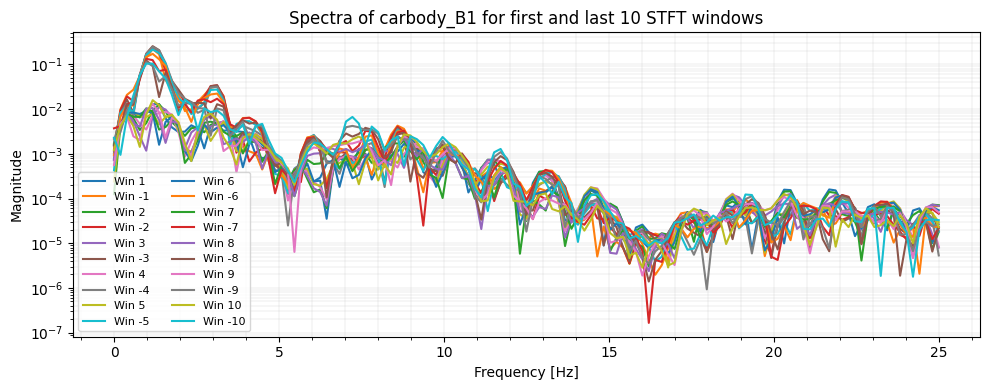

305
129


In [13]:
###############
### TESTING ###
###############

stft_magnitude_test = stft_results[sensor_names[0]]["stft_magnitude"]
Zxx_test = stft_results[sensor_names[0]]["Zxx"]
f_test = stft_results[sensor_names[0]]["f"]

"""
NOTES

Zxx[:, k] is the complex spectrum of the k-th time window
Zxx[f, :] is the time evolution of one frequency bin
stft_magnitude[:, k] is the magnitude spectrum of window k
"""
n_windows_to_plot = 10

plt.figure(figsize=(10, 4))

for k in range(n_windows_to_plot):
    spectrum_complex_first = Zxx_test[:, k]
    spectrum_complex_last = Zxx_test[:, -k-1]
    spectrum_magnitude_first = np.abs(spectrum_complex_first)
    spectrum_magnitude_last = np.abs(spectrum_complex_last)

    plt.semilogy(f_test, spectrum_magnitude_first, label=f"Win {k+1}")
    plt.semilogy(f_test, spectrum_magnitude_last, label=f"Win {-k-1}")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title(f"Spectra of {sensor_names[0]} for first and last {n_windows_to_plot} STFT windows")

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

In [ ]:
# Separate db per sensor? Makes more sense --> dictionary, no combination of sensor fingerprints
# Real scenario, so we re-process the data
# STFT inputs

"""
NOTES
In Shazam the whole music is converted into fingerprints first, i.e. 44100 Hz recording to e.g. 150 seconds, with window length of 2048 samples (0.05 second). Then a 5 second snippet is converted into fingerprints (~107 frames, 535 fingerprints) to be matched against the analyzed music (~3230 frames, 16150 fingerprints).
In our case the window is much longer while the simulation length is the same and sampling frequency is much lower, so there are some limitations to this study. We need to remove n = half window length / stride frames (=6) from the beginning and the end, and also want to analyze about 30 full frames, so the total number of frames to be analyzed is about 6 + 30 + 6 = 42.
Scipy has a weird windowing algorithm, so the total # of windows/frames is (N+2*L/2+L)/H+2=N/H+2 => 42 = N/20 + 2 => N=800 => t=720/50=16 seconds.
Segmenting data into 16 second snippets
"""

# Example sensor and scenario
scenario = "S7_IRREG1_K1"
sensor_name = "B1_right"
acceleration, time, dist = sensor_data[sensor_name]

# segmentation of simulation signal for database
seg_len_sec = 16.0
seg_hop_sec = 1.6  # 90% overlap
seg_len_samples = int(seg_len_sec * fs)  # 800
seg_hop_samples = int(seg_hop_sec * fs)  # 80

segments = []  # list of (seg_signal, seg_start_time, seg_index)

N = len(acceleration)
seg_index = 0
start = 0
while start + seg_len_samples <= N:
    end = start + seg_len_samples
    seg_signal = acceleration[start:end]
    seg_start_time = time[start]  # absolute time from simulation start
    segments.append((seg_signal, seg_start_time, seg_index))
    seg_index += 1
    start += seg_hop_samples

In [ ]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\02 Python\Experiment_2.pkl"
if os.path.exists(filename):
    print("Loading cached results...")
    with open(filename, "rb") as f:
        data = pickle.load(f)
    confusion_dict_grad = data["confusion_dict"]
    accuracy_dict_grad = data["accuracy_dict"]

else:
    print("Generating results...")

    confusion_dict_grad = {}
    accuracy_dict_grad = {}
    for matcher in ("plain", "unique", "offset"):
        confusion_dict_grad[matcher] = {}
        accuracy_dict_grad[matcher] = {}
        for sensor_name in sensor_names:

            hash_to_entries, scenario_list = flatten_db_for_sensor(train_db.db, sensor_name)
            grouped_scenarios = ["Baseline", "Aging rubber spring", "Degraded rubber spring", "Broken coil spring", "Worse track quality"]
            scenario_to_idx = {sc: i for i, sc in enumerate(grouped_scenarios)}
            S = len(grouped_scenarios)
            confusion = np.zeros((S, S), dtype=int)

            for true_scenario, sensor, seg_idx in test_segments:
                if sensor != sensor_name:
                    continue
                sample_fps = fingerprints_per_segment[(true_scenario, sensor, seg_idx)]

                if matcher == "plain":
                    scores = match_plain_hash_count(sample_fps, hash_to_entries)
                elif matcher == "unique":
                    scores = match_unique_hashes(sample_fps, hash_to_entries)
                elif matcher == "offset":
                    scores, _ = match_offset_consistency(sample_fps, hash_to_entries)
                else:
                    raise ValueError("Unknown matcher")

                if not scores:
                    continue  # no match, treat as miss (optional: count separately)

                # Predict scenario with max score
                predicted_scenario = max(scores.items(), key=lambda x: x[1])[0]

                true_group = map_scenario_grad(true_scenario)
                pred_group = map_scenario_grad(predicted_scenario)

                i = scenario_to_idx[true_group]
                j = scenario_to_idx[pred_group]
                confusion[i, j] += 1

            total = confusion.sum()
            correct = np.trace(confusion)
            accuracy = correct / total if total > 0 else 0.0

            confusion_dict_grad[matcher][sensor_name] = confusion
            accuracy_dict_grad[matcher][sensor_name] = accuracy

            with open(filename, "wb") as f:
                pickle.dump({
                    "confusion_dict": confusion_dict_grad,
                    "accuracy_dict": accuracy_dict_grad
                }, f)